# Cell Classification with Geneformer

# Libraries

In [1]:
import scanpy as sc
import pickle
import datetime
import shutil
from geneformer import Classifier
from datasets import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Generate timestamps for output directory
current_datetime = datetime.datetime.now()
datestamp_long = f"{str(current_datetime.year)[-2:]}{current_datetime.month:02d}{current_datetime.day:02d}{current_datetime.hour:02d}{current_datetime.minute:02d}{current_datetime.second:02d}"
datestamp_short = f"{str(current_datetime.year)[-2:]}{current_datetime.month:02d}{current_datetime.day:02d}"

In [3]:
import os
cwd = os.getcwd()
print(f"Current working directory: {cwd}")

Current working directory: /data/hdd1/users/dvoulgari/Project/notebook


---
---

# Preparation of the data

### **RUN THIS ONLY ONCE**

In [5]:
# Define the directory where the 10x data files are extracted
extracted_files_dir = "../sc_data"

# Define the samples and their original prefixes
sample_info = {
    "cTEC1": "GSM4838951_cTecI",
    "cTEC2": "GSM4838952_cTecII",
    "mTEC1": "GSM4838953_mTecI",
    "mTEC2": "GSM4838954_mTecII",
}

# Define the new directory where structured data will be stored
structured_data_dir = os.path.join(extracted_files_dir, "structured_10x_data")
os.makedirs(structured_data_dir, exist_ok=True)
print(f"Created directory for structured data: {structured_data_dir}")

# Process each sample
for sample_label, prefix in sample_info.items():
    sample_output_dir = os.path.join(structured_data_dir, sample_label)
    os.makedirs(sample_output_dir, exist_ok=True)
    print(f"\nProcessing sample: {sample_label}. Creating directory: {sample_output_dir}")

    # Define source and destination paths for each file type
    files_to_move = {
        f"{prefix}_barcodes.tsv.gz": "barcodes.tsv.gz",
        f"{prefix}_features.tsv.gz": "features.tsv.gz",
        f"{prefix}_matrix.mtx.gz": "matrix.mtx.gz",
    }

    for original_filename, target_filename in files_to_move.items():
        src_path = os.path.join(extracted_files_dir, original_filename)
        dest_path = os.path.join(sample_output_dir, target_filename)

        if os.path.exists(src_path):
            try:
                shutil.move(src_path, dest_path)
                print(f"  Moved and renamed: {original_filename} -> {sample_label}/{target_filename}")
            except Exception as e:
                print(f"  ERROR moving {original_filename}: {e}")
        else:
            print(f"  WARNING: Source file not found: {original_filename}")

print("\nAll files organized into sample-specific directories.")

Created directory for structured data: ../sc_data/structured_10x_data

Processing sample: cTEC1. Creating directory: ../sc_data/structured_10x_data/cTEC1

Processing sample: cTEC2. Creating directory: ../sc_data/structured_10x_data/cTEC2

Processing sample: mTEC1. Creating directory: ../sc_data/structured_10x_data/mTEC1

Processing sample: mTEC2. Creating directory: ../sc_data/structured_10x_data/mTEC2

All files organized into sample-specific directories.


In [6]:
# Define the base directory where the structured data is
structured_data_dir = "../sc_data/structured_10x_data" 

# List of the individual sample directory names 
sample_labels = ["cTEC1", "cTEC2", "mTEC1", "mTEC2"]

adata_objects = {}
for sample_label in sample_labels:
    sample_path = os.path.join(structured_data_dir, sample_label)

    if not os.path.exists(sample_path):
        print(f"Error: Structured sample directory not found for {sample_label} at {sample_path}.")
        print("Please run the file organization script first.")
        continue

    print(f"Loading data for {sample_label} from {sample_path}...")
    try:
        adata = sc.read_10x_mtx(
            sample_path,
            var_names='gene_ids', # Use gene names from features.tsv
            cache=True # Cache the loaded data for faster re-loading
        )
        # Add a 'sample_id' column to distinguish cells from different samples
        adata.obs['sample_id'] = sample_label
        # Ensure cell barcodes are unique across samples
        adata.obs_names_make_unique()

        adata_objects[sample_label] = adata
        print(f"Successfully loaded {sample_label}: {adata.n_obs} cells, {adata.n_vars} genes.")
    except Exception as e:
        print(f"Failed to load {sample_label}: {e}")

# Concatenate the AnnData objects
if not adata_objects:
    print("No AnnData objects were loaded. Cannot combine.")
else:
    print("\nConcatenating all AnnData objects...")
    combined_adata = sc.concat(adata_objects.values(), axis=0, join='outer', merge='unique')

    print(f"\nCombined AnnData object has {combined_adata.n_obs} cells and {combined_adata.n_vars} genes.")
    print("This 'combined_adata' object now contains the raw read counts for all samples.")
    print(combined_adata)

Loading data for cTEC1 from ../sc_data/structured_10x_data/cTEC1...
Successfully loaded cTEC1: 1705 cells, 33538 genes.
Loading data for cTEC2 from ../sc_data/structured_10x_data/cTEC2...
Successfully loaded cTEC2: 3814 cells, 33538 genes.
Loading data for mTEC1 from ../sc_data/structured_10x_data/mTEC1...
Successfully loaded mTEC1: 1806 cells, 33538 genes.
Loading data for mTEC2 from ../sc_data/structured_10x_data/mTEC2...
Successfully loaded mTEC2: 4100 cells, 33538 genes.

Concatenating all AnnData objects...

Combined AnnData object has 11425 cells and 33538 genes.
This 'combined_adata' object now contains the raw read counts for all samples.
AnnData object with n_obs × n_vars = 11425 × 33538
    obs: 'sample_id'
    var: 'gene_symbols', 'feature_types'


In [7]:
# Adress the warning about unique cell names
print("Making observation names unique...")
combined_adata.obs_names_make_unique()
print("Observation names are now unique.")

Making observation names unique...
Observation names are now unique.


In [8]:
print("\nPerforming basic quality control...")
# Filter out cells that have very few genes expressed (e.g., < 200 genes)
sc.pp.filter_cells(combined_adata, min_genes=200)
print(f"Filtered cells: Remaining {combined_adata.n_obs} cells.")

# Filter out genes that are expressed in very few cells (e.g., < 3 cells)
sc.pp.filter_genes(combined_adata, min_cells=3)
print(f"Filtered genes: Remaining {combined_adata.n_vars} genes.")

print("Basic QC complete. Current AnnData object state:")
print(combined_adata)


Performing basic quality control...
Filtered cells: Remaining 11176 cells.
Filtered genes: Remaining 23937 genes.
Basic QC complete. Current AnnData object state:
AnnData object with n_obs × n_vars = 11176 × 23937
    obs: 'sample_id', 'n_genes'
    var: 'gene_symbols', 'feature_types', 'n_cells'


## Add the cell_type column for Geneformer

In [9]:
print("\nAdding 'cell_type' column based on 'sample_id'...")
# Mapping the specific sample IDs to the broader cell types
cell_type_mapping = {
    "cTEC1": "cTEC",
    "cTEC2": "cTEC",
    "mTEC1": "mTEC",
    "mTEC2": "mTEC"
}

# Apply the mapping
combined_adata.obs['cell_type'] = combined_adata.obs['sample_id'].map(cell_type_mapping)

# Convert the new 'cell_type' column to a categorical type
combined_adata.obs['cell_type'] = combined_adata.obs['cell_type'].astype('category')

print("Counts for the new 'cell_type' column:")
print(combined_adata.obs['cell_type'].value_counts())


Adding 'cell_type' column based on 'sample_id'...
Counts for the new 'cell_type' column:
cell_type
mTEC    5799
cTEC    5377
Name: count, dtype: int64


In [10]:
# Verify a few cells
print("\nFirst 10 cells with their sample_id and new cell_type:")
print(combined_adata.obs[['sample_id', 'cell_type']].head())

# Verify some gene names
print("\nFirst 10 gene names:")
print(combined_adata.var_names[:10])


First 10 cells with their sample_id and new cell_type:
                   sample_id cell_type
AAACCCACACAAGTTC-1     cTEC1      cTEC
AAACCCACACCCTAGG-1     cTEC1      cTEC
AAACCCATCACAGAGG-1     cTEC1      cTEC
AAACGAAGTTGCGGAA-1     cTEC1      cTEC
AAACGCTGTCAATCTG-1     cTEC1      cTEC

First 10 gene names:
Index(['ENSG00000238009', 'ENSG00000239945', 'ENSG00000237491',
       'ENSG00000177757', 'ENSG00000225880', 'ENSG00000230368',
       'ENSG00000230699', 'ENSG00000223764', 'ENSG00000187634',
       'ENSG00000188976'],
      dtype='object')


Until now we have:
- Compined the 4 samples
- Raw counts
- Observation names unique
- Basic QC applied (cells and genes filtered)
- Ensembl IDs as .var_names
- 'cell_type' column added to .obs

In [11]:
# Save the combined AnnData object for future use
combined_adata_file = "../data/original_dataset/human_thymus_10x_data.h5ad"

# Make sure that the folder exists - we want a seperate folder, because else tokenization will be applied to all .h5ad files
if os.makedirs(os.path.dirname(combined_adata_file), exist_ok=True):
    print(f"Directory {os.path.dirname(combined_adata_file)} created or already exists.")

combined_adata.write(combined_adata_file)
print(f"\nCombined AnnData object saved to {combined_adata_file}")


Combined AnnData object saved to ../data/original_dataset/human_thymus_10x_data.h5ad


`Checkpoint`
- Run until this point only once. 
- Saved the combined data in the form that the Geneformer wants in a .h5ad file, to only load this final file for the rest steps.

---
---

# Load the data

In [4]:
# Load the saved AnnData object
h5ad_filepath = "../data/original_dataset/human_thymus_10x_data.h5ad"

print(f"Loading AnnData object from: {h5ad_filepath}")
adata = sc.read_h5ad(h5ad_filepath)
print("AnnData object loaded successfully!")
print(adata)

Loading AnnData object from: ../data/original_dataset/human_thymus_10x_data.h5ad
AnnData object loaded successfully!
AnnData object with n_obs × n_vars = 11176 × 23937
    obs: 'sample_id', 'n_genes', 'cell_type'
    var: 'gene_symbols', 'feature_types', 'n_cells'


# Verify and adjust the dataset in the form that Geneformer expects

Regarding the total UMI/read counts per cell, Geneformer expects 'n_counts' and the scanpy workflow produced 'n_genes'. So we need to change that, to match the name of the column that Geneformer expects.

In [5]:
# Assuming adata.X contains raw counts (or count-like values suitable for summing)
actual_total_counts = adata.X.sum(axis=1)

print(f"First 5 values of 'n_genes': {adata.obs['n_genes'].head().tolist()}")
print(f"First 5 values of actual total counts (sum of adata.X): {actual_total_counts[:5].tolist()}")

First 5 values of 'n_genes': [1934, 1228, 2073, 1199, 2007]
First 5 values of actual total counts (sum of adata.X): [[4713.0], [2246.0], [6982.0], [2622.0], [5019.0]]


- First 5 values of 'n_genes': [1934, 1228, 2073, 1199, 2007]: These are the number of unique genes detected in the first five cells.

- First 5 values of actual total counts (sum of adata.X): [[4713.0], [2246.0], [6982.0], [2622.0], [5019.0]]: These are the total sum of all UMI/read counts for the first five cells.

The "actual total counts" are significantly higher than the "number of genes." This is expected, as a single gene can have many UMI/read counts associated with it.

`Conclusion:`
Given this comparison, 'n_genes' does not represent the total counts. The adata.X.sum(axis=1) provides the accurate total UMI/read counts per cell. That is what Geneformer needs.

In [6]:
# Set 'n_counts' in adata.obs 
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [7]:
# Ensure 'ensembl_id' is in adata.var
adata.var['ensembl_id'] = adata.var_names.tolist()

# Define the classification label column
classification_label_column = 'cell_type' 

# Ensure there are no NaNs in the chosen label column
if adata.obs[classification_label_column].isnull().any():
    print(f"Warning: NaN values found in '{classification_label_column}'. Removing cells with NaN labels.")
    adata = adata[adata.obs[classification_label_column].notna()].copy()
    print(f"New shape after removing NaNs: {adata.shape}")

# Geneformer works best with string labels, not categories or ontology terms directly. Ensure the column is of string type.
adata.obs[classification_label_column] = adata.obs[classification_label_column].astype(str)

# Save the updated AnnData object for tokenization
updated_adata_file = "../data/human_thymus_for_geneformer.h5ad"
adata.write(updated_adata_file)
print(adata)
print(f"\nAnnData object prepared for Geneformer and saved to {updated_adata_file}")

AnnData object with n_obs × n_vars = 11176 × 23937
    obs: 'sample_id', 'n_genes', 'cell_type', 'n_counts'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'ensembl_id'

AnnData object prepared for Geneformer and saved to ../data/human_thymus_for_geneformer.h5ad


# Configuration

In [8]:
from geneformer.tokenizer import TranscriptomeTokenizer
from datasets import Dataset

data_directory = "../data/" 
output_directory = "../outputs/"
os.makedirs(output_directory, exist_ok=True)
output_prefix = "ht_for_geneformer"

In [9]:
# Check the number of CPU cores available
num_cpu_cores = os.cpu_count()
print(f"This computer has {num_cpu_cores} CPU cores available.")

# Option 1: Use all available cores for maximum speed for this task
nproc_value = num_cpu_cores

# Or Option 2: Use all but one core to keep some system responsiveness
if num_cpu_cores > 1:
    nproc_value_responsive = num_cpu_cores - 1
else:
    nproc_value_responsive = 1 

print(f"Use nproc={nproc_value} for fastest tokenization, or nproc={nproc_value_responsive} to keep some system responsiveness.")

This computer has 96 CPU cores available.
Use nproc=96 for fastest tokenization, or nproc=95 to keep some system responsiveness.


# Tokenization

In [10]:
# Define folder for tokenized data
tokenized_data = "../data/tokenized_data/"
os.makedirs(tokenized_data, exist_ok=True)

In [11]:
# Run the Geneformer Tokenizer 

# Initialize the tokenizer with the classification label column and number of processes
tk = TranscriptomeTokenizer({"cell_type": 'cell_type'}, nproc=nproc_value_responsive, model_input_size=2048) # NOTE: This call will create the .dataset folder, but *not* the .pkl!!!

print(f"\nStarting tokenization from {data_directory}...")

# The tokenizer will find 'human_thymus_for_geneformer.h5ad' in data_directory
tk.tokenize_data(data_directory, tokenized_data, output_prefix, file_format="h5ad")

print("Tokenization complete!")


Starting tokenization from ../data/...
Tokenizing ../data/human_thymus_for_geneformer.h5ad


100%|██████████| 22/22 [00:43<00:00,  1.99s/it]


../data/human_thymus_for_geneformer.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.
Tokenization complete!


`CHECKPOINT`

- The correct input file (juman_thymus_for_geneformer.h5ad) was found and processed.

- The 'filter_pass' warning means all cells are included, which is typical.

- Raw counts are now converted to a Geneformer-ready tokenized dataset.

---
---

# Setting up training parameters

In [ ]:
# Path from the Tokenization Step

# Define directoriy for model checkpoints 
model_directory = "../model/"

# Generate a unique timestamp for the output directory 
current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"

output_directory_this_run = os.path.join(output_directory, f"ht_classifier_run_{datestamp}")
os.makedirs(output_directory_this_run, exist_ok=True)

output_prefix_classifier_run = "classifier"

# Define Pre-trained Geneformer Model Path
pretrained_model_path = os.path.join(model_directory, "Geneformer/gf-6L-30M-i2048") # selected based on resource availability and dataset's needs

In [13]:
# Classifier Training Arguments
training_args = {
    "num_train_epochs": 2.0, 
    "learning_rate": 8.04e-4, 
    "lr_scheduler_type": "polynomial", 
    "warmup_steps": 900, 
    "weight_decay": 0.258828, 
    "per_device_train_batch_size": 4, 
    "seed": 73 # for reproducibility
}

In [14]:
# Geneformer Classifier Initialization
classifier = Classifier(
    classifier="cell",
    cell_state_dict={"state_key": "cell_type", "states": "all"},
    training_args=training_args,
    max_ncells=None, # Use all cells
    freeze_layers=2, 
    num_crossval_splits=1, # this will make the Classifier perform a single train/validation split (85/15 by default) 
    forward_batch_size=64, # adjust based on memory
    nproc=nproc_value_responsive
)

In [15]:
# Prepare Data for Train/Test Split
print("Preparing data for explicit random cell-based train/test split...")

# Define a folder to save the train and test datasets
train_test_data = os.path.join(output_directory_this_run, f"data_splitted")
os.makedirs(train_test_data, exist_ok=True)

# Use the tokenized dataset file as input
tokenized_dataset_file = os.path.join(tokenized_data, f"{output_prefix}.dataset")
print(tokenized_dataset_file)

Preparing data for explicit random cell-based train/test split...
../data/tokenized_data/ht_for_geneformer.dataset


In [21]:
classifier.prepare_data(
    input_data_file=tokenized_dataset_file,
    output_directory=train_test_data, # Save the split datasets here
    output_prefix=output_prefix_classifier_run, 
    split_id_dict=None, 
)
print("Data split into random train and test datasets.")

# Classifier.prepare_data() *automatically* adds "_labeled" to the prefix.
actual_file_prefix_on_disk = f"{output_prefix_classifier_run}_labeled"

# Define paths to the newly created split datasets
prepared_train_data_file = os.path.join(train_test_data, f"{actual_file_prefix_on_disk}_train.dataset")
prepared_test_data_file = os.path.join(train_test_data, f"{actual_file_prefix_on_disk}_test.dataset")

print(f"Train dataset: {prepared_train_data_file}")
print(f"Test dataset: {prepared_test_data_file}")


Data split into random train and test datasets.
Train dataset: ../outputs/ht_classifier_run_250630170813/data_splitted/classifier_labeled_train.dataset
Test dataset: ../outputs/ht_classifier_run_250630170813/data_splitted/classifier_labeled_test.dataset


In [22]:
id_class_dict_path = "../outputs/ht_classifier_run_250630170813/data_splitted/classifier_id_class_dict.pkl"
print(id_class_dict_path)

../outputs/ht_classifier_run_250630170813/data_splitted/classifier_id_class_dict.pkl


---

### Define the processing functions

In [23]:
# Load, Cast, and Resave BOTH datasets (float to int conversion)

def cast_and_rename_label(example): # tokenization produce float input_ids and labels, training requires integers
    if 'input_ids' in example and isinstance(example['input_ids'], list):
        example['input_ids'] = [int(x) for x in example['input_ids']]

    if 'label' in example and isinstance(example['label'], float):
        if example['label'].is_integer():
            example['label'] = int(example['label'])
    elif 'labels' in example: # Check for 'labels'
        if isinstance(example['labels'], list) and len(example['labels']) == 1:
            if isinstance(example['labels'][0], float) and example['labels'][0].is_integer():
                example['label'] = int(example['labels'][0])
                del example['labels']
            elif isinstance(example['labels'][0], int):
                 example['label'] = example['labels'][0]
                 del example['labels']
        elif isinstance(example['labels'], float) and example['labels'].is_integer():
            example['label'] = int(example['labels'])
            del example['labels']
        elif isinstance(example['labels'], int):
            example['label'] = example['labels']
            del example['labels']
    return example

---

In [24]:
# Create a subdirectory for processed tokenized data (within the current run's output)
processed_output_directory = os.path.join(output_directory_this_run, "processed_for_training")
os.makedirs(processed_output_directory, exist_ok=True)
print(f"\nCreated processed output directory: {processed_output_directory}")


Created processed output directory: ../outputs/ht_classifier_run_250630170813/processed_for_training


In [25]:
# Load, apply transformation and save

# Process Train dataset
train_dataset_raw = Dataset.load_from_disk(prepared_train_data_file)
print(f"Loaded Train Dataset. Number of examples: {len(train_dataset_raw)}")
train_dataset_processed= cast_and_rename_label(train_dataset_raw)
print("Train dataset processing complete.")

# Define final save path for the fully processed dataset
final_processed_train_data_file = os.path.join(processed_output_directory, f"{output_prefix_classifier_run}_train_processed.dataset")
print(f"Saving fully processed Train dataset to: {final_processed_train_data_file}")
train_dataset_processed.save_to_disk(final_processed_train_data_file)
print("Fully processed Train dataset saved.")

Loaded Train Dataset. Number of examples: 10058
Train dataset processing complete.
Saving fully processed Train dataset to: ../outputs/ht_classifier_run_250630170813/processed_for_training/classifier_train_processed.dataset
Fully processed Train dataset saved.


In [26]:
# Process Test dataset
test_dataset_raw = Dataset.load_from_disk(prepared_test_data_file)
print(f"Loaded Test Dataset. Number of examples: {len(test_dataset_raw)}")
test_dataset_processed= cast_and_rename_label(test_dataset_raw)
print("Test dataset processing complete.")

# Define final save path for the fully processed dataset
final_processed_test_data_file = os.path.join(processed_output_directory, f"{output_prefix_classifier_run}_test_processed.dataset")
print(f"Saving fully processed Test dataset to: {final_processed_test_data_file}")
test_dataset_processed.save_to_disk(final_processed_test_data_file)
print("Fully processed Test dataset saved.")

Loaded Test Dataset. Number of examples: 1118
Test dataset processing complete.
Saving fully processed Test dataset to: ../outputs/ht_classifier_run_250630170813/processed_for_training/classifier_test_processed.dataset
Fully processed Test dataset saved.


### GPU Configuration

In [27]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.cuda.empty_cache()

True
2


# Train the model

In [28]:
# Train the model on the prepared training data
print(f"Starting classifier training at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
all_metrics = classifier.validate(
    prepared_input_data_file=final_processed_train_data_file,
    model_directory=pretrained_model_path,
    id_class_dict_file=id_class_dict_path,
    output_directory=output_directory_this_run,
    output_prefix=output_prefix_classifier_run,
    predict_eval=True, # Ensure predictions are saved for plotting
    # n_hyperopt_trials=50, # If we want to perform hyperparameter optimization
)
print(f"Classifier training complete at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Starting classifier training at 2025-06-30 17:15:19


  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../model/Geneformer/gf-6L-30M-i2048 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.310500,0.326618,0.899821,0.899551
2,0.155900,0.132791,0.957961,0.957936


  0%|          | 0/18 [00:00<?, ?it/s]

Classifier training complete at 2025-06-30 17:18:56


# Evaluation

In [29]:
classifier = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "cell_type", "states": "all"},  
                forward_batch_size=4,
                nproc=nproc_value_responsive
                )

Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters. Please note: these defaults are not recommended to be used uniformly across tasks.


In [30]:
model_checkpoint_dir = '../outputs/ht_classifier_run_250630170813/250630_geneformer_cellClassifier_classifier/ksplit1'

# Construct the paths for the test_data
test_data = os.path.join(output_directory_this_run, f"{output_prefix_classifier_run}_labeled_test.dataset")

# Define a dedicated output directory for the evaluation and plots
evaluation_output_dir_name = "evaluation_output"
evaluation_output_dir = os.path.join(output_directory_this_run, evaluation_output_dir_name)
os.makedirs(evaluation_output_dir, exist_ok=True)

# Define the prefix for the output evaluation files and plots
evaluation_output_prefix = f"{output_prefix}_evaluation"

In [31]:
print(f"Model directory: {model_checkpoint_dir}")
print(f"ID Class Dict: {id_class_dict_path}")
print(f"Test Data File: {test_data}")
print(f"Evaluation Output Dir: {evaluation_output_dir}")
print(f"Evaluation Output Prefix: {evaluation_output_prefix}")

Model directory: ../outputs/ht_classifier_run_250630170813/250630_geneformer_cellClassifier_classifier/ksplit1
ID Class Dict: ../outputs/ht_classifier_run_250630170813/data_splitted/classifier_id_class_dict.pkl
Test Data File: ../outputs/ht_classifier_run_250630170813/classifier_labeled_test.dataset
Evaluation Output Dir: ../outputs/ht_classifier_run_250630170813/evaluation_output
Evaluation Output Prefix: ht_for_geneformer_evaluation


In [32]:
# Evaluate the saved model
all_metrics_test = classifier.evaluate_saved_model(
    model_directory=model_checkpoint_dir,
    id_class_dict_file=id_class_dict_path,
    test_data_file=final_processed_test_data_file,
    output_directory=evaluation_output_dir,
    output_prefix=evaluation_output_prefix,
)
print("\nGeneformer evaluation initiated with corrected paths using existing variables.")

  0%|          | 0/280 [00:00<?, ?it/s]


Geneformer evaluation initiated with corrected paths using existing variables.


<Figure size 1000x1000 with 0 Axes>

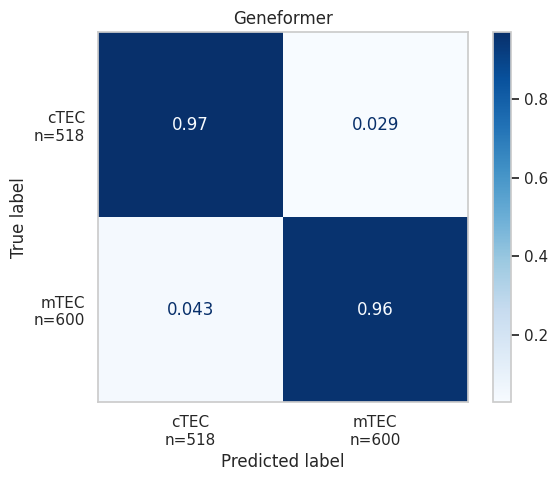

In [33]:
classifier.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory=evaluation_output_dir,
        output_prefix=output_prefix
)

**Key observations:**

* **High Accuracy for cTEC:** The model correctly classified 97% of cTEC instances (True Positive: 0.97). Only 2.9% of actual cTEC instances were misclassified as mTEC (False Negative: 0.029).
* **High Accuracy for mTEC:** Similarly, the model correctly classified 96% of mTEC instances (True Positive: 0.96). Only 4.3% of actual mTEC instances were misclassified as cTEC (False Negative: 0.043).
* **Low Misclassification Rates:** Both false positive rates (instances incorrectly classified as cTEC when they were mTEC, and vice-versa) are very low (0.043 and 0.029 respectively).
* **Balanced Dataset (Approximate):** The number of samples for each class is relatively balanced (n=518 for cTEC and n=600 for mTEC), which is good for evaluating model performance without bias towards a majority class.

**Overall:** The Geneformer model appears to perform very well in distinguishing between cTEC and mTEC, exhibiting high precision and recall for both classes, as indicated by the high values on the diagonal and low values off the diagonal.

In [34]:
id_class_dict_pred_path = os.path.join(evaluation_output_dir, f"{evaluation_output_prefix}_pred_dict.pkl")

<Figure size 1500x1500 with 0 Axes>

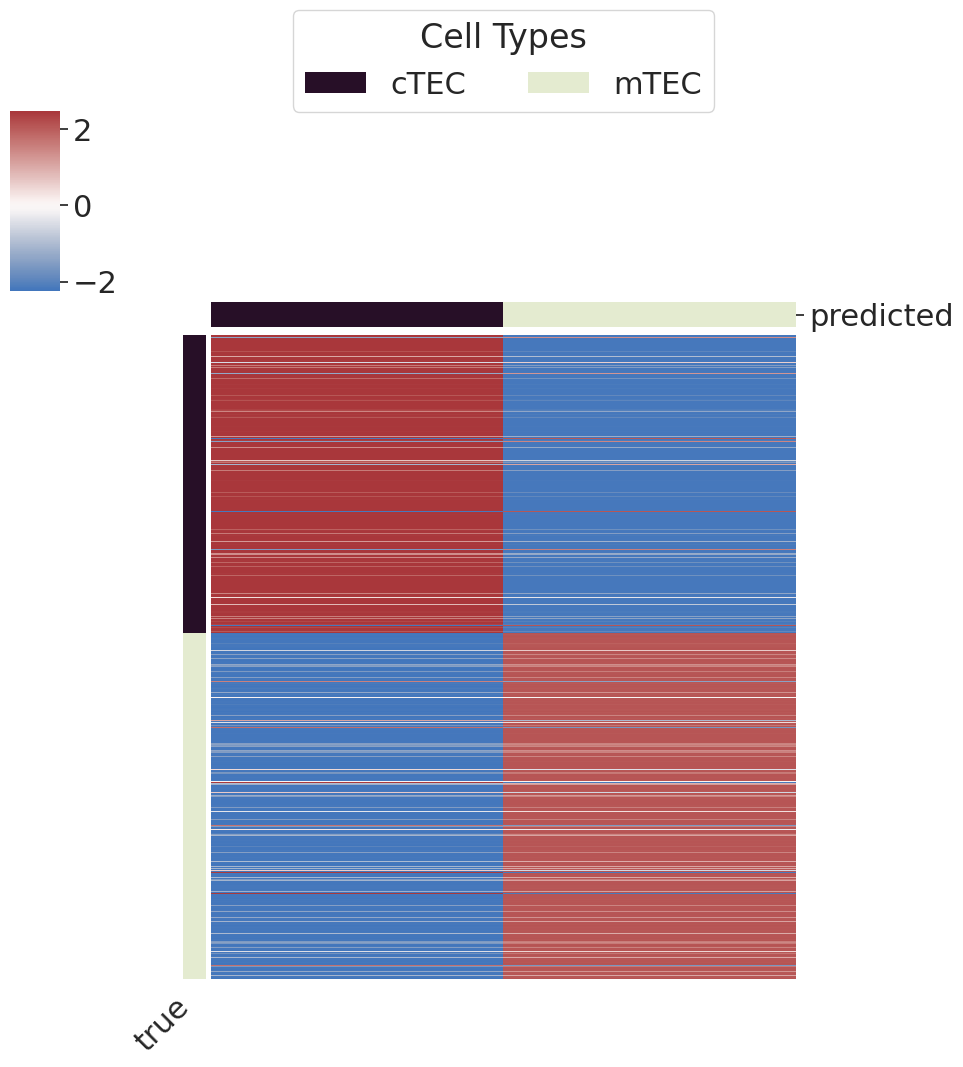

In [35]:
# Plot predictions
classifier.plot_predictions(
    predictions_file=id_class_dict_pred_path,
    id_class_dict_file=id_class_dict_path,
    title="Cell Types",
    output_directory=evaluation_output_dir,
    output_prefix=evaluation_output_prefix,
)

This image presents a heat map visualizing the classification results, likely of a model distinguishing between "cTEC" and "mTEC" cell types, similar to the previous confusion matrix.

**Key elements and interpretation:**

* **Color Bar (Top Left):** Indicates a range of values from -2 (blue) to +2 (red), with 0 being white/light. This scale likely represents a continuous score or a differential expression value that the model uses for classification.
* **Legends (Top Center):**
    * **"cTEC" (black):** Represents the cTEC cell type.
    * **"mTEC" (light green/beige):** Represents the mTEC cell type.
* **Top Bar (Predicted Label):** The black and light green/beige bar at the top represents the **predicted cell types** for each sample. The black segment corresponds to samples predicted as cTEC, and the light green/beige segment to samples predicted as mTEC.
* **Left Bar (True Label):** The black and light green/beige bar on the left represents the **true cell types** for each sample. The black segment corresponds to actual cTEC samples, and the light green/beige segment to actual mTEC samples.
* **Heat Map Body:**
    * **Top-Left Quadrant (True cTEC, Predicted cTEC):** This section shows actual cTEC samples that were correctly predicted as cTEC. The prevalence of red indicates that for these correctly classified cTEC samples, the underlying values (represented by the color scale) tend to be positive.
    * **Top-Right Quadrant (True cTEC, Predicted mTEC):** This section represents actual cTEC samples that were *incorrectly* predicted as mTEC (False Negatives from the cTEC perspective). The blue colors here suggest that for these misclassified cTEC samples, the underlying values tended to be negative, leading the model to misclassify them as mTEC.
    * **Bottom-Left Quadrant (True mTEC, Predicted cTEC):** This section represents actual mTEC samples that were *incorrectly* predicted as cTEC (False Positives from the cTEC perspective). The red colors here suggest that for these misclassified mTEC samples, the underlying values tended to be positive, leading the model to misclassify them as cTEC.
    * **Bottom-Right Quadrant (True mTEC, Predicted mTEC):** This section shows actual mTEC samples that were correctly predicted as mTEC. The prevalence of blue indicates that for these correctly classified mTEC samples, the underlying values tend to be negative.

**In summary:** This heat map provides a visual breakdown of the model's performance, showing not just the counts of correct/incorrect classifications (as in a confusion matrix) but also the underlying feature values that drive these classifications. The distinct color patterns in the correctly classified quadrants (red for cTEC, blue for mTEC) and the opposing patterns in the misclassified quadrants help to understand where the model might be "confused" based on the input features.

In [36]:
all_metrics_test

{'conf_matrix':       cTEC  mTEC
 cTEC   503    15
 mTEC    26   574,
 'macro_f1': np.float64(0.963178869018213),
 'acc': 0.9633273703041145,
 'all_roc_metrics': {'mean_tpr': array([0.        , 0.79833333, 0.89166667, 0.96833333, 0.975     ,
         0.98      , 0.98      , 0.98166667, 0.98666667, 0.98666667,
         0.99      , 0.99      , 0.99      , 0.99      , 0.99      ,
         0.99      , 0.99      , 0.99      , 0.99166667, 0.99166667,
         0.995     , 0.995     , 0.995     , 0.995     , 0.995     ,
         0.99666667, 0.99666667, 0.99666667, 0.99666667, 0.99666667,
         0.99666667, 0.99666667, 0.99666667, 0.99666667, 0.99666667,
         0.99666667, 0.99666667, 0.99666667, 0.99666667, 0.99666667,
         0.99666667, 0.99666667, 0.99666667, 0.99666667, 0.99666667,
         0.99666667, 0.99666667, 0.99666667, 0.99666667, 0.99666667,
         0.99666667, 0.99666667, 0.99666667, 0.99666667, 0.99666667,
         0.99666667, 0.99666667, 0.99666667, 0.99666667, 0.99666667,

In [38]:
def plot_roc_curve(roc_metrics_dict, model_name, output_directory, output_prefix):
    """
    Plots the Receiver Operating Characteristic (ROC) curve and saves it to a file.
    """
    mean_fpr = roc_metrics_dict['mean_fpr']
    mean_tpr = roc_metrics_dict['mean_tpr']
    roc_auc = roc_metrics_dict['all_roc_auc']

    plt.figure(figsize=(10, 10))
    plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2,
             label=f'ROC curve ({model_name} AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.50)')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR) / Recall')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


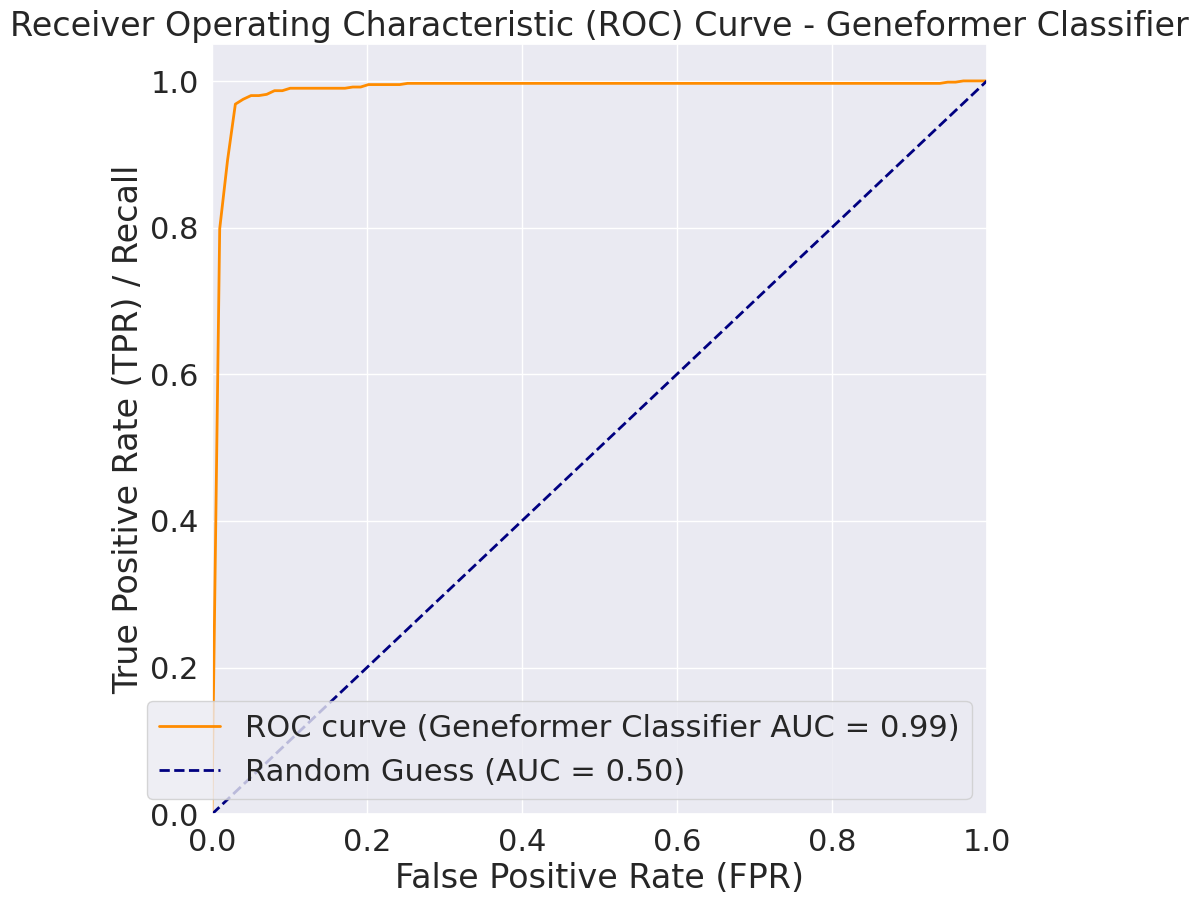

In [39]:
plot_roc_curve(
    all_metrics_test['all_roc_metrics'],
    model_name="Geneformer Classifier",
    output_directory=evaluation_output_dir,
    output_prefix=evaluation_output_prefix
)

* **X-axis:** False Positive Rate (FPR)
* **Y-axis:** True Positive Rate (TPR) / Recall
* **Orange Curve:** Represents the Geneformer Classifier's performance. It stays very close to the top-left corner, indicating high TPR at low FPR.
* **Blue Dashed Line:** Represents a random classifier (AUC = 0.50).
* **AUC (Area Under the Curve) = 0.99:** This exceptionally high AUC indicates that the Geneformer Classifier is **highly accurate and discriminative**, performing significantly better than random chance and showing strong ability to distinguish between classes across various thresholds.

In [40]:
# Define a dedicated output directory for the embeddings and plots
embeddings_output_dir_name = "embeddings_output"
embeddings_output_dir = os.path.join(output_directory_this_run, embeddings_output_dir_name)
os.makedirs(embeddings_output_dir, exist_ok=True)

# Define the prefix for the output embedding files and plots
embeddings_output_prefix = f"{output_prefix}_embeddings"

In [41]:
# Initiate EmbExtractor
from geneformer import EmbExtractor

In [45]:
embex = EmbExtractor(
    model_type="CellClassifier",
    num_classes=2, # Set to 2 for mTEC and cTEC classes
    filter_data=None,
    max_ncells=1000, 
    emb_layer=0, 
    emb_label=["cell_type"], 
    labels_to_plot=["cell_type"], 
    forward_batch_size=200,
    nproc=nproc_value_responsive
)

# Extract embeddings from input data
# This will save the embeddings as a .pkl file in embeddings_output_dir
embs = embex.extract_embs(
    '../outputs/ht_classifier_run_250630170813/250630_geneformer_cellClassifier_classifier/ksplit1',
    '../data/tokenized_data/ht_for_geneformer.dataset',
    output_directory=embeddings_output_dir,
    output_prefix=embeddings_output_prefix
)

  0%|          | 0/5 [00:00<?, ?it/s]

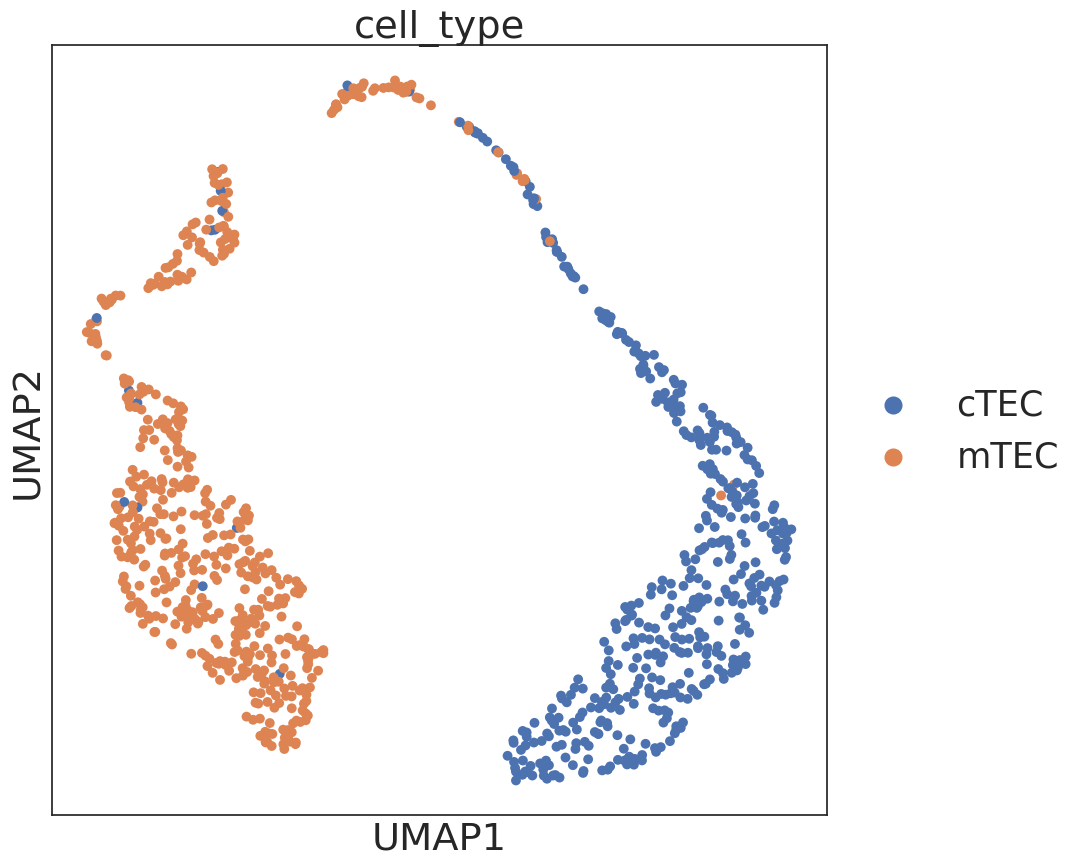

<Figure size 1000x1000 with 0 Axes>

In [46]:
# Plot UMAP of cell embeddings
embex.plot_embs(embs=embs, 
                plot_style="umap",
                output_directory=embeddings_output_dir,
                output_prefix=embeddings_output_prefix
            )

* **Distinct Clusters:** The most striking feature is the formation of two very distinct and well-separated clusters, one predominantly blue (cTEC) and the other predominantly orange (mTEC). There are very few intermingled points between the two main clusters.

**Why the separation is so good:**

The excellent separation of the cTEC and mTEC cell types in this UMAP plot strongly suggests that:

1.  **Strong Intrinsic Differences:** The underlying high-dimensional features (e.g., gene expression profiles) that define cTEC and mTEC cells are highly distinct. There are clear and robust differences in their molecular characteristics.
2.  **Effective Feature Representation:** The data used to generate this UMAP effectively captures these inherent differences between the cell types.
3.  **Biological Relevance:** Such clear separation in a UMAP plot often correlates with true biological distinctions between cell populations. It indicates that cTEC and mTEC are genuinely distinct cell types with unique molecular signatures, not merely subtly different states of the same cell type.
4.  **Suitability for Classification:** When data shows such clear separation in a dimensionality reduction plot, it implies that these cell types would be relatively easy to classify using machine learning models, as seen in the high performance of the "Geneformer" classifier with an AUC of 0.99. The model effectively learns these inherent differences.

**Overall:** This UMAP plot visually confirms that cTEC and mTEC are highly distinct cell populations based on their underlying features, which explains why a classification model like Geneformer would achieve such high accuracy in distinguishing them.

---
---

# Comparison with models trained from scratch

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)
from sklearn.utils import resample
from joblib import parallel_backend
import matplotlib.patches as mpatches

In [2]:
# Load data
adata = sc.read_h5ad("../data/human_thymus_for_geneformer.h5ad")
X = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X
y_raw = adata.obs["cell_type"].astype(str).values

# Encode labels to numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
num_classes = len(np.unique(y))

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.33, stratify=y, random_state=42
)

In [5]:
results = []

# Confidence Interval (bootstrapped accuracy)
def bootstrap_confidence_interval(model, X_test, y_test, n_iterations=100, alpha=0.05):
    scores = []
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X_test, y_test)
        score = accuracy_score(y_resampled, model.predict(X_resampled))
        scores.append(score)
    lower = np.percentile(scores, 100 * (alpha / 2))
    upper = np.percentile(scores, 100 * (1 - alpha / 2))
    return np.mean(scores), lower, upper

# Evaluation function with CI handling
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test_decoded = label_encoder.inverse_transform(y_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    
    # Calculate metrics
    acc = accuracy_score(y_test_decoded, y_pred_decoded)
    f1_macro = f1_score(y_test_decoded, y_pred_decoded, average="macro")
    f1_micro = f1_score(y_test_decoded, y_pred_decoded, average="micro")
    mean_ci, ci_low, ci_high = bootstrap_confidence_interval(model, X_test, y_test)
    
    print(f"\n{name}")
    print(classification_report(y_test_decoded, y_pred_decoded))
    print("Confusion matrix:\n", confusion_matrix(y_test_decoded, y_pred_decoded))
    print(f"Bootstrapped Accuracy CI (95%): ({ci_low:.3f}, {ci_high:.3f})")

    # Store results with clear CI naming
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Accuracy CI Lower": ci_low,  
        "Accuracy CI Upper": ci_high,  
        "F1 Macro": f1_macro,
        "F1 Micro": f1_micro
    })

In [6]:
print("\n" + "="*50)
print("TRAINING BASELINE MODELS")
print("="*50)

baseline_models = {
    "Logistic Regression (baseline)": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest (baseline)": RandomForestClassifier(n_estimators=100, n_jobs=-1),
    "XGBoost (baseline)": XGBClassifier(
        tree_method="gpu_hist",
        predictor="gpu_predictor",
        n_jobs=-1,
        eval_metric="mlogloss",
        objective="multi:softmax",
        num_class=num_classes
    )
}

with parallel_backend('threading', n_jobs=96):
    for name, model in baseline_models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        evaluate_model(name, model, X_test, y_test)


TRAINING BASELINE MODELS

Training Logistic Regression (baseline)...

Logistic Regression (baseline)
              precision    recall  f1-score   support

        cTEC       0.98      0.95      0.97      1775
        mTEC       0.96      0.98      0.97      1914

    accuracy                           0.97      3689
   macro avg       0.97      0.97      0.97      3689
weighted avg       0.97      0.97      0.97      3689

Confusion matrix:
 [[1688   87]
 [  29 1885]]
Bootstrapped Accuracy CI (95%): (0.963, 0.974)

Training Random Forest (baseline)...

Random Forest (baseline)
              precision    recall  f1-score   support

        cTEC       0.99      0.96      0.97      1775
        mTEC       0.96      0.99      0.98      1914

    accuracy                           0.98      3689
   macro avg       0.98      0.97      0.98      3689
weighted avg       0.98      0.98      0.98      3689

Confusion matrix:
 [[1702   73]
 [  17 1897]]
Bootstrapped Accuracy CI (95%): (0.971, 0

In [ ]:
print("\n" + "="*50)
print("TRAINING TUNED MODELS")
print("="*50)

tuned_models = {
    "Logistic Regression (tuned)": {
        "estimator": LogisticRegression(max_iter=1000, n_jobs=-1),
        "params": {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"]}
    },
    "Random Forest (tuned)": {
        "estimator": RandomForestClassifier(n_jobs=-1),
        "params": {"n_estimators": [100, 200], "max_depth": [None, 10, 20]}
    },
    "XGBoost (tuned)": {
        "estimator": XGBClassifier(
            tree_method="gpu_hist",
            predictor="gpu_predictor",
            n_jobs=-1,
            eval_metric="mlogloss",
            objective="multi:softmax",
            num_class=num_classes
        ),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5],
            "learning_rate": [0.01, 0.1]
        }
    }
}

with parallel_backend('threading', n_jobs=96):
    for name, config in tuned_models.items():
        print(f"\nTuning {name}...")
        grid = GridSearchCV(
            config["estimator"],
            config["params"],
            cv=StratifiedKFold(n_splits=3),
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train, y_train)
        evaluate_model(name, grid.best_estimator_, X_test, y_test)


TRAINING TUNED MODELS

Tuning Logistic Regression (tuned)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Logistic Regression (tuned)
              precision    recall  f1-score   support

        cTEC       0.98      0.95      0.97      1775
        mTEC       0.96      0.98      0.97      1914

    accuracy                           0.97      3689
   macro avg       0.97      0.97      0.97      3689
weighted avg       0.97      0.97      0.97      3689

Confusion matrix:
 [[1688   87]
 [  29 1885]]
Bootstrapped Accuracy CI (95%): (0.963, 0.975)

Tuning Random Forest (tuned)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Random Forest (tuned)
              precision    recall  f1-score   support

        cTEC       0.99      0.95      0.97      1775
        mTEC       0.96      0.99      0.97      1914

    accuracy                           0.97      3689
   macro avg       0.97      0.97      0.97      3689
weighted avg       0.97      0.97      0.

[19:26:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[19:26:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

[19:26:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[19:26:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

[19:26:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[19:26:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

[19:26:02] WARNING: /workspace/src


XGBoost (tuned)
              precision    recall  f1-score   support

        cTEC       0.99      0.98      0.98      1775
        mTEC       0.98      0.99      0.98      1914

    accuracy                           0.98      3689
   macro avg       0.98      0.98      0.98      3689
weighted avg       0.98      0.98      0.98      3689

Confusion matrix:
 [[1733   42]
 [  18 1896]]
Bootstrapped Accuracy CI (95%): (0.980, 0.987)


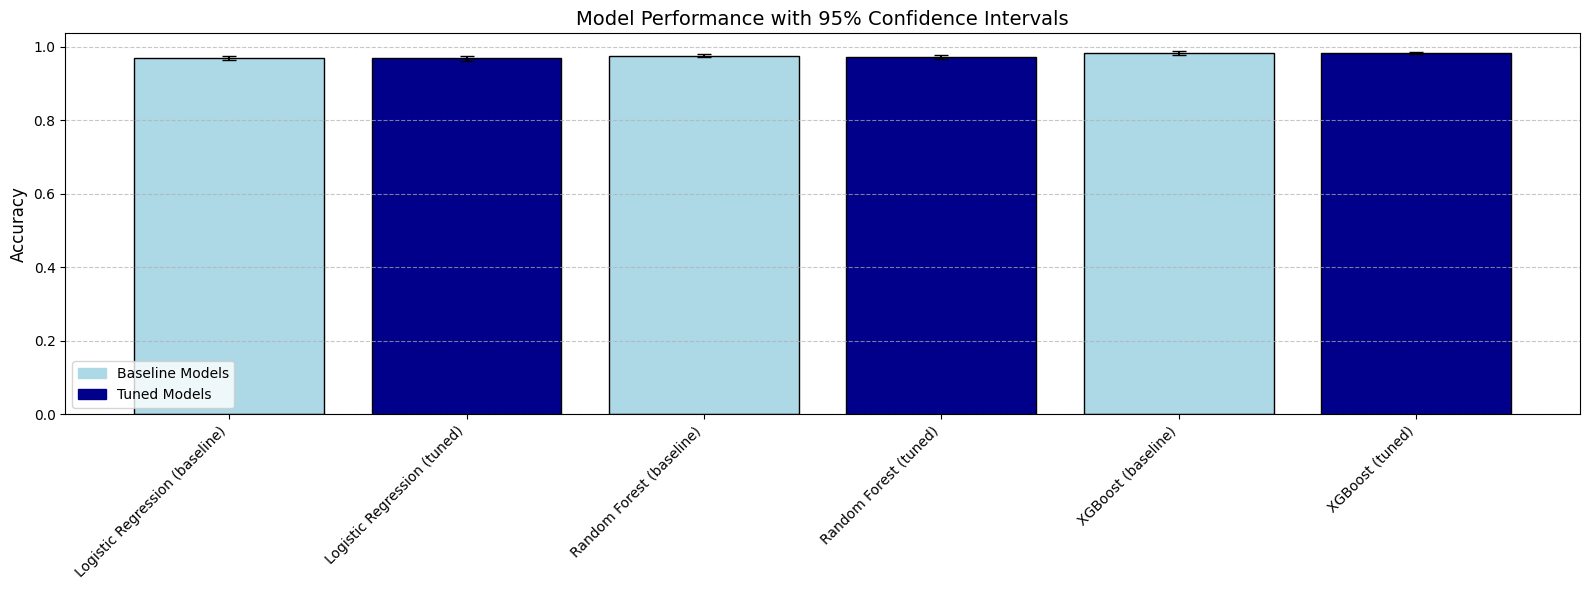


FINAL RESULTS:
| Model                          |   Accuracy |   Accuracy CI Lower |   Accuracy CI Upper |   F1 Macro |   F1 Micro |
|:-------------------------------|-----------:|--------------------:|--------------------:|-----------:|-----------:|
| Logistic Regression (baseline) |      0.969 |               0.963 |               0.974 |      0.968 |      0.969 |
| Logistic Regression (tuned)    |      0.969 |               0.963 |               0.975 |      0.968 |      0.969 |
| Random Forest (baseline)       |      0.976 |               0.971 |               0.980 |      0.976 |      0.976 |
| Random Forest (tuned)          |      0.972 |               0.967 |               0.977 |      0.972 |      0.972 |
| XGBoost (baseline)             |      0.983 |               0.979 |               0.987 |      0.983 |      0.983 |
| XGBoost (tuned)                |      0.984 |               0.980 |               0.987 |      0.984 |      0.984 |


In [ ]:
# Results Visualizations
results_df = pd.DataFrame(results)

# Sort results
model_order = [
    "Logistic Regression (baseline)", "Logistic Regression (tuned)",
    "Random Forest (baseline)", "Random Forest (tuned)",
    "XGBoost (baseline)", "XGBoost (tuned)",
]
results_df = results_df.set_index("Model").loc[model_order].reset_index()

# Plot 
plt.figure(figsize=(16, 6))
colors = ['lightblue' if "(baseline)" in x else 'darkblue' for x in results_df["Model"]]

plt.bar(
    results_df["Model"],
    results_df["Accuracy"],
    color=colors,
    edgecolor='black',
    yerr=[results_df["Accuracy"] - results_df["Accuracy CI Lower"], 
          results_df["Accuracy CI Upper"] - results_df["Accuracy"]],
    capsize=5
)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Model Performance with 95% Confidence Intervals", fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add legend
baseline_patch = mpatches.Patch(color='lightblue', label='Baseline Models')
tuned_patch = mpatches.Patch(color='darkblue', label='Tuned Models')
plt.legend(handles=[baseline_patch, tuned_patch])

plt.tight_layout()
plt.show()

# Show all metrics
print("\nFINAL RESULTS:")
print(results_df.to_markdown(index=False, floatfmt=".3f"))

This table presents the final performance metrics for three machine learning models (Logistic Regression, Random Forest, and XGBoost) in both their baseline and tuned configurations. The metrics include Accuracy, its 95% Confidence Interval (CI), F1 Macro, and F1 Micro scores.

* **Overall Excellent Performance:** All models achieve exceptionally high accuracy, with values consistently above 0.96 (96%). This indicates that all models perform very well on this classification task.
* **Minimal Tuning Impact:** Hyperparameter tuning ("tuned" versions) generally yields only marginal improvements, if any, over the "baseline" models. For example, Logistic Regression's accuracy remains at 0.969 for both baseline and tuned, and Random Forest's accuracy even slightly decreases after tuning (from 0.976 to 0.972). XGBoost shows a minor increase (0.983 to 0.984).
* **Highest Performance with XGBoost:** XGBoost, particularly its tuned version, demonstrates the highest accuracy at 0.984, along with the highest F1 Macro and F1 Micro scores, suggesting it is the best performing model among those tested.
* **Tight Confidence Intervals:** The narrow 95% confidence intervals for accuracy across all models (e.g., +/- 0.003 to 0.005) indicate high consistency and reliability of the reported performance.
* **Consistent F1 Scores:** F1 Macro and F1 Micro scores are very close to the accuracy values for all models, which is expected given the high overall accuracy and likely well-balanced classes, further confirming strong performance across both precision and recall.